# 네이버 영화리뷰 감성분석 도전

## 데이터 준비와 확인

In [1]:
!pip install gensim

!pip install --upgrade gensim==3.8.3

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어보자
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

#### data_loader
데이터 중복 제거

NaN 결측치 제거

한국어 토크나이저로 토큰화

불용어 제거

사전 word_to_index 구성

텍스트 스트링을 사전 인덱스 스트링으로 변환

X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    #train 전처리
    train_data.drop_duplicates(subset=['document'], inplace=True) # 데이터 중복 제거
    train_data = train_data.dropna(how='any')                     # 결측치 제거       
    #Test 전처리
    test_data.drop_duplicates(subset=['document'], inplace=True) # 데이터 중복 제거
    test_data = test_data.dropna(how = 'any')                    # 결측치 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # stopwords 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # stopwords 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(70000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print("train data 개수 :", len(X_train))
print("test data 개수 :", len(X_test))

train data 개수 : 146182
test data 개수 : 49157


In [4]:
#딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0
[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
라벨:  1
[24, 205, 30113]
재 밓었다그래서보는것을추천한다
라벨:  0
[8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]
이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정
라벨:  0
[22672, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 16052, 22673, 427, 3102, 1766, 6]
익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 커스틴 던스트 너무나 이뻐 보였 다
라벨:  1
[675, 22674, 18655, 131, 420, 185, 1547, 712, 65, 1694, 715, 53, 375, 192, 271, 5, 4, 69, 4, 11, 2179, 122, 750, 4]
걸음마 뗀 3 세 부터 초등 학교 1 학년 생 인 8 살 용 영화 . ㅋㅋㅋ . .. 별반 개 아까움 .
라벨:  0
[253, 381, 9, 384, 2012, 55, 15, 817, 6, 4]
긴장감 을 제대로 살려 내 지 못했 다 .
라벨:  0
[232, 1450, 144, 6, 425, 756, 10855, 16053, 52, 1532, 290, 99, 250, 4, 4, 28, 855, 29, 353, 652, 540, 509, 583, 6, 3318, 4, 8895, 22, 1460, 1460, 4, 4, 71, 304, 17, 6, 52, 104, 8, 77, 22, 30114, 43]
반개 아깝 다 욕 나온다 이응경 길

## 모델 구성을 위한 데이터 분석 및 가공

### 데이터셋 내의 문장 길이 분포

### 적절한 최대 문장 길이 지정

### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]

num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)


print(X_train.shape)

(146182, 41)


In [8]:
# train data set에서 80:20의 비율로 train과 validation으로 분리
#RNN에서는 순서가 중요하므로 shuffle은 진행하지 않도록 한다.
# train set
partial_X_train = X_train[:int(X_train.shape[0]*0.8)]
partial_y_train = y_train[:int(y_train.shape[0]*0.8)]

# validation set
x_valid = X_train[int(X_train.shape[0]*0.8):]
y_valid = y_train[int(X_train.shape[0]*0.8):]

print('partial_x_train :', partial_X_train.shape)
print('partial_y_train :', partial_y_train.shape)
print('x_valid :', x_valid.shape)
print('y_valid :', y_valid.shape)

partial_x_train : (116945, 41)
partial_y_train : (116945,)
x_valid : (29237, 41)
y_valid : (29237,)


## 모델 구성 및 validation set 구성

### RNN 모델

In [9]:
# 어휘 사전의 크기
vocab_size = 10000
word_vector_dim = 128  
# 워드 벡터의 차원수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  
# 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 4384      
_________________________________________________________________
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,284,545
Trainable params: 1,284,545
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 5s 8ms/step - loss: 0.7041 - accuracy: 0.8034 - val_loss: 0.5155 - val_accuracy: 0.8438
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.4345 - accuracy: 0.8618 - val_loss: 0.4133 - val_accuracy: 0.8515
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3626 - accuracy: 0.8772 - val_loss: 0.3927 - val_accuracy: 0.8548
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3312 - accuracy: 0.8868 - val_loss: 0.3861 - val_accuracy: 0.8555
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3064 - accuracy: 0.8959 - val_loss: 0.3820 - val_accuracy: 0.8566
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2842 - accuracy: 0.9063 - val_loss: 0.3853 - val_accuracy: 0.8534
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2669 - accuracy: 0.9129 - val_loss: 0.3954 - val_accuracy: 0.8511
Epoch 

### 그래프 시각화

In [11]:
history_dict = history.history

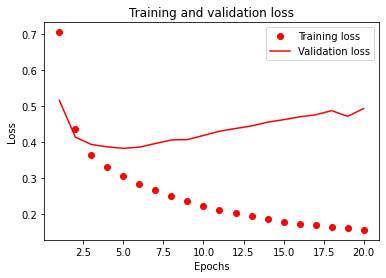

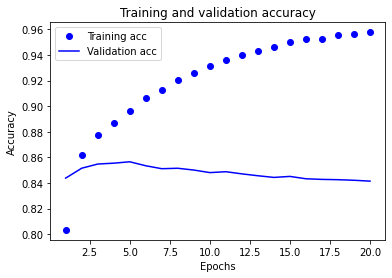

In [12]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 테스트 평가

In [13]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5118 - accuracy: 0.8341
[0.5117892622947693, 0.8341233134269714]


### 1-D CNN 모델

In [14]:
# 어휘 사전의 크기(10,000개의 단어)
vocab_size = 10000  
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(32, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(32, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(16, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          44832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### 1-D CNN 모델 훈련

In [15]:
# 학습 환경 설정
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# 모델 학습
history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/5
457/457 [==============================] - 5s 7ms/step - loss: 0.3975 - accuracy: 0.8133 - val_loss: 0.3280 - val_accuracy: 0.8584
Epoch 2/5
457/457 [==============================] - 3s 6ms/step - loss: 0.2684 - accuracy: 0.8890 - val_loss: 0.3294 - val_accuracy: 0.8601
Epoch 3/5
457/457 [==============================] - 3s 6ms/step - loss: 0.1721 - accuracy: 0.9347 - val_loss: 0.3759 - val_accuracy: 0.8547
Epoch 4/5
457/457 [==============================] - 3s 6ms/step - loss: 0.0921 - accuracy: 0.9682 - val_loss: 0.4950 - val_accuracy: 0.8441
Epoch 5/5
457/457 [==============================] - 3s 6ms/step - loss: 0.0571 - accuracy: 0.9813 - val_loss: 0.5729 - val_accuracy: 0.8449


### 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


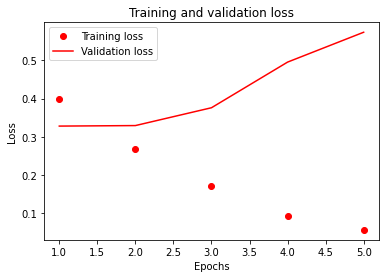

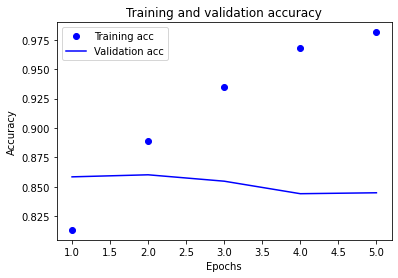

In [16]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 테스트 평가

In [17]:
results = model2.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5896 - accuracy: 0.8412
[0.5895631909370422, 0.8412433862686157]


### GlobalMaxPooling1D() 모델

In [18]:
vocab_size = 10000  
word_vector_dim = 200   

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(16, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                3216      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 2,003,233
Trainable params: 2,003,233
Non-trainable params: 0
_________________________________________________________________


### GlobalMaxPooling1D() 모델 훈련

In [19]:
# 학습 환경 설정
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# 모델 학습
history = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/5
457/457 [==============================] - 2s 4ms/step - loss: 0.4254 - accuracy: 0.8167 - val_loss: 0.3433 - val_accuracy: 0.8509
Epoch 2/5
457/457 [==============================] - 2s 4ms/step - loss: 0.2996 - accuracy: 0.8742 - val_loss: 0.3371 - val_accuracy: 0.8543
Epoch 3/5
457/457 [==============================] - 2s 4ms/step - loss: 0.2498 - accuracy: 0.8992 - val_loss: 0.3454 - val_accuracy: 0.8569
Epoch 4/5
457/457 [==============================] - 2s 4ms/step - loss: 0.2040 - accuracy: 0.9216 - val_loss: 0.3666 - val_accuracy: 0.8525
Epoch 5/5
457/457 [==============================] - 2s 4ms/step - loss: 0.1578 - accuracy: 0.9434 - val_loss: 0.4021 - val_accuracy: 0.8507


### 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


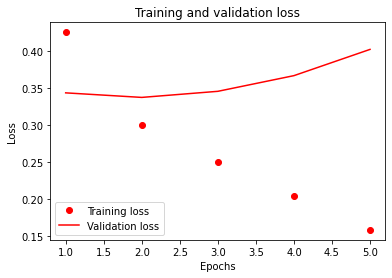

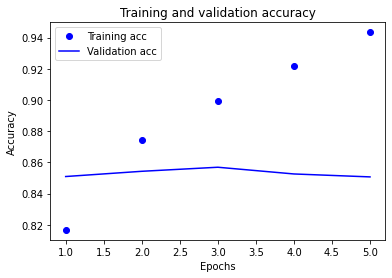

In [20]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 테스트 평가

In [21]:
results = model3.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4135 - accuracy: 0.8457
[0.41351208090782166, 0.8456984758377075]


## 학습된 Embedding 레이어 분석

In [22]:
import gensim

gensim.__version__

'3.8.3'

In [23]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    
# (vocab_size, embedding_dim)

(10000, 128)


In [24]:
import os
from gensim import models     # gensim : 워드벡터를 다루는데 유용한 패키지

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model2.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [25]:
# 임베딩 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['좋']
vector

array([ 0.04002763,  0.11042672,  0.0705272 , -0.07922912, -0.00207875,
       -0.05959496,  0.02463673,  0.09533185, -0.03221181, -0.06713165,
        0.02102545, -0.03422381,  0.03245359,  0.03921298, -0.04923128,
       -0.01229176, -0.04937562, -0.03030475,  0.01795933,  0.07719096,
        0.02075107,  0.00438063,  0.09065286,  0.0575302 , -0.07142103,
        0.078635  , -0.0711986 ,  0.07508343,  0.09974683, -0.05183615,
       -0.0772666 , -0.01092433, -0.10506873, -0.09158409,  0.00230189,
       -0.00109   ,  0.01876266, -0.01405656,  0.02588102, -0.00579005,
        0.00389949,  0.00093371,  0.09411059, -0.06091054, -0.09731386,
        0.02158676,  0.0477482 ,  0.04289344,  0.05139301, -0.0423282 ,
        0.02508151,  0.07547294,  0.1123451 ,  0.07908954,  0.03055206,
       -0.01943605, -0.03923942,  0.10192194,  0.0132806 , -0.01857843,
        0.07659   , -0.00487318, -0.10886452, -0.01870912,  0.04203385,
        0.08100782, -0.07117388, -0.07825751, -0.11579326, -0.07

In [26]:
word_vectors.similar_by_word("좋")
# 별로 유사하지 않음
# 학습이 잘 되지 않음

[('제법', 0.6234259605407715),
 ('올려야', 0.602027952671051),
 ('지리', 0.59603351354599),
 ('돌아보', 0.5944850444793701),
 ('충실', 0.5942865610122681),
 ('친근', 0.5864992141723633),
 ('알차', 0.585963249206543),
 ('멋', 0.5844545960426331),
 ('돌파', 0.5827163457870483),
 ('탄탄', 0.5823382139205933)]

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

### 임베딩 모델(ko.bin)을 활용한 전이학습

In [27]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector.shape

/tmp/ipykernel_1491/1025019223.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['영화']


(200,)

In [28]:
# 유사한 단어와 그 유사도 확인
word2vec.wv.most_similar("재미")  # 학습이 잘 되어 유사함

[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

### 임베딩 메트릭스

In [29]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000     # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_1491/1410859879.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_1491/1410859879.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


### 학습된 Word2Vec 모델 사용

In [30]:
# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련

In [31]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/5
1828/1828 [==============================] - 13s 6ms/step - loss: 0.3879 - accuracy: 0.8231 - val_loss: 0.3229 - val_accuracy: 0.8597
Epoch 2/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.2859 - accuracy: 0.8798 - val_loss: 0.3067 - val_accuracy: 0.8690
Epoch 3/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.2407 - accuracy: 0.9003 - val_loss: 0.3125 - val_accuracy: 0.8689
Epoch 4/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.1972 - accuracy: 0.9210 - val_loss: 0.3389 - val_accuracy: 0.8667
Epoch 5/5
1828/1828 [==============================] - 11s 6ms/step - loss: 0.1548 - accuracy: 0.9400 - val_loss: 0.3892 - val_accuracy: 0.8631


In [ ]:
### Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


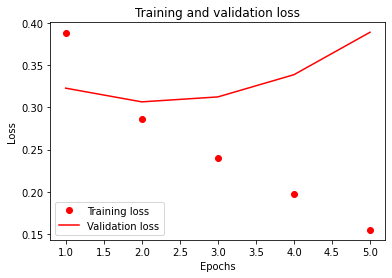

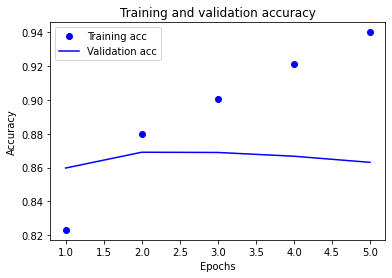

In [32]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델 평가

In [33]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)   # 정확도가 0.85으로 개선됨

1537/1537 - 3s - loss: 0.3942 - accuracy: 0.8616
[0.3941735029220581, 0.861586332321167]
